In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras import losses
import numpy as np
import matplotlib.pyplot as plt

model = VGG19(weights='imagenet', include_top=False)

model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [2]:
def reshape_f(x):
    x=tf.reshape(x,[tf.shape(x)[0]*tf.shape(x)[1],tf.shape(x)[2]])
    x=tf.transpose(x)
    return x

In [3]:
def make_gen_input():
    gen_input=np.random.randn(224,224,3)
    return gen_input

In [4]:
def make_con_feature(tef,layer):
    con_feature=feature_extractor(tef)[layer][0,:,:,:]
    con_feature=reshape_f(con_feature)
    return con_feature

In [5]:
def con_loss(con_feature,gen_con_feature):
    return tf.reduce_sum(tf.square(con_feature - gen_con_feature))

In [6]:
def make_st_feature(tef,layer):
    matrix=make_con_feature(tef,layer)
    st_feature = tf.matmul(matrix, matrix, transpose_b=True)
    return st_feature

In [7]:
def single_style_loss(st_feature,gen_st_feature,M):
    nu=tf.reduce_sum(tf.square(st_feature - gen_st_feature))
    de= tf.constant(4.0) * tf.cast(tf.square(tf.shape(st_feature)[0]),tf.float32) * tf.cast(M,tf.float32) # tf.cast(tf.square(M),tf.float32)にするとMが大きいとき動かないのでMを2回に分けて割る
    a1= tf.divide(nu,de)
    a2= tf.divide(a1,tf.cast(M,tf.float32))
    return  a2

In [8]:
def style_loss(st_tf,gen_tf):
    st_loss=tf.zeros(shape=())
    for layer in st_layers:
        st_feature=make_st_feature(st_tf,layer)
        gen_st_feature=make_st_feature(gen_tf,layer)
        M=tf.shape(make_con_feature(st_tf,layer))[1]
        st_loss=st_loss+single_style_loss(st_feature,gen_st_feature,M)/len(st_layers)
    return st_loss

In [9]:
def total_loss(gen_tf,a,b):    
    con_feature=make_con_feature(con_tf,con_layer)
    gen_con_feature=make_con_feature(gen_tf,con_layer)
    cl=con_loss(con_feature,gen_con_feature)
    
    sl=style_loss(st_tf,gen_tf)
    
    return a*cl+b*sl

In [10]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

feature_extractor = Model(inputs=model.inputs, outputs=outputs_dict)

In [11]:
con_input_path = 'elephant.jpg'
st_input_path='gogh.jpg'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


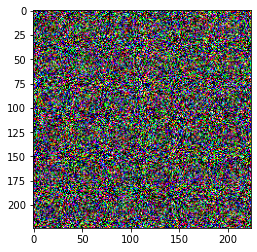

In [12]:
gen_input=make_gen_input()
plt.imshow(gen_input)
gen_input = image.img_to_array(gen_input)
gen_input = np.expand_dims(gen_input, axis=0)
gen_input = preprocess_input(gen_input)

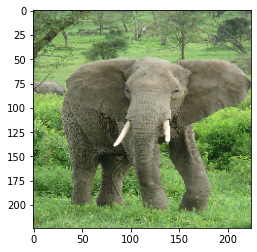

In [13]:
con_input = image.load_img(con_input_path, target_size=(224, 224))
plt.imshow(con_input)
keras.preprocessing.image.save_img('content.png', con_input)
con_input = image.img_to_array(con_input)
con_input = np.expand_dims(con_input, axis=0)
con_input = preprocess_input(con_input)

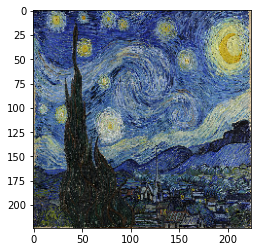

In [14]:
st_input = image.load_img(st_input_path, target_size=(224, 224))
plt.imshow(st_input)
keras.preprocessing.image.save_img('style.png', st_input)
st_input = image.img_to_array(st_input)
st_input = np.expand_dims(st_input, axis=0)
st_input = preprocess_input(st_input)

In [15]:
gen_tf=tf.Variable(con_input)
con_tf=tf.Variable(con_input)
st_tf=tf.Variable(st_input)

In [16]:
con_layer='block4_conv2'
st_layers=['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1']

In [17]:
con_weight=1e-9
st_weight=1e-6

In [18]:
iterations = 100

In [19]:
@tf.function
def grad_and_loss(gen_tf):
    with tf.GradientTape() as tape:
        loss=total_loss(gen_tf,con_weight,st_weight)
    grad = tape.gradient(loss, gen_tf)
    return grad,loss

In [22]:
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

for i in range(1, iterations + 1):
    grad,loss = grad_and_loss(gen_tf)
    optimizer.apply_gradients([(grad, gen_tf)])
    if i% 10 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
result = gen_tf[0,:,:,:].numpy()
keras.preprocessing.image.save_img('result.png', result)

Iteration 10: loss=1053.99
Iteration 20: loss=827.39
Iteration 30: loss=703.15
Iteration 40: loss=623.62
Iteration 50: loss=567.65
Iteration 60: loss=525.85
Iteration 70: loss=493.23
Iteration 80: loss=466.80
Iteration 90: loss=444.88
Iteration 100: loss=426.41
